In [6]:
import os
import sys

import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import math
import statistics
from scipy.optimize import curve_fit

from numpy.fft import fft2
import numpy as np

from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits

from __future__ import absolute_import

module_path = '~/lib/lsst_stack/stack⁩/miniconda3-4.3.21-10a4fa6⁩/DarwinX86⁩/'
if module_path not in sys.path:
    sys.path.append(module_path)

    
os.environ['EOTEST_DIR'] = '/Users/duncan/lib/eotest/python'
import lsst
import lsst.afw.display as afwDisplay
from lsst.eotest.fitsTools import fitsWriteto
import lsst.eotest.sensor
import lsst.eotest.image_utils as imutils
from AmplifierGeometry import makeAmplifierGeometry

from tvregdiff import TVRegDiff

ModuleNotFoundError: No module named 'lsst.afw'

In [7]:
dir(lsst)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'pkgutil']

In [4]:
%config InlineBackend.figure_format = 'retina'

In [5]:
def get_CCD_from_fits(filename, bias=False):
    image_file = get_pkg_data_filename(filename)
    
    bottom_row = np.array([])
    for i in range(1,9):
        image_data = fits.getdata(image_file, ext=i)
        if bias:
            image_data = image_data - fits.getheader(filename,i)['AVGBIAS']
        if bottom_row.size == 0:
            bottom_row = image_data
        else:
            bottom_row = np.column_stack((bottom_row, image_data))

    top_row = np.array([])
    for i in range(1,9):
        image_data = fits.getdata(image_file, ext=i+8)
        if bias:
            image_data = image_data - fits.getheader(filename,i+8)['AVGBIAS']
        if top_row.size == 0:
            top_row = image_data
        else:
            top_row = np.column_stack((image_data, top_row))

    return np.vstack((top_row, bottom_row))

def get_segment(data,a,b, buf=30):
    if not (data.shape == (4096, 4608)): return np.array([])
    else: return data[2048*b + buf : 2048*(b+1) - buf - 1 , 576*a + buf : 576*(a+1) - buf - 1]

In [162]:
flats_directory = os.fsencode('data')
image_files = []
for file in os.listdir(flats_directory):
    filename = os.fsdecode(file)
    if filename.endswith('.fits'): 
        image_files.append(filename)

In [163]:
image_files

['ITL-3800C-458_median_dark_bp.fits',
 'ITL-3800C-088_median_dark_bp.fits',
 'ITL-3800C-432_median_dark_bp.fits']

In [316]:
image.header

AttributeError: 'lsst.afw.image.image.image.ImageF' object has no attribute 'header'

In [567]:
#imagefile = 'data/ITL-3800C-088_median_dark_bp.fits'
#imagefile = 'data/ITL-3800C-432_median_dark_bp.fits' # bright column
imagefile = 'data-10932/ITL-3800C-225_dark_dark_000_10932_20190514181349.fits'

#image = get_CCD_from_fits(imagefile,bias=False)
data = fits.open(get_pkg_data_filename(imagefile))

In [568]:
ccd.amp_geom.serial_overscan

Box2I(minimum=Point2I(512, 0), dimensions=Extent2I(64, 2048))

In [569]:
#ccd = lsst.eotest.sensor.MaskedCCD(imagefile)


#mimage = lsst.afw.image.MaskedImageF(imagefile)#, imutils.dm_hdu(3))
#image_untrimmed = mimage.getImage()
image_untrimmed = lsst.afw.image.ImageF(imagefile,imutils.dm_hdu(3))
nrows = len(image_untrimmed.array)
amp = makeAmplifierGeometry(imagefile)
image = imutils.trim(image_untrimmed, amp.imaging)
#flatim = np.ravel(image.array)
#biasimage = im.bias_image_using_overscan(10)
#biasimage = ccd.bias_image_using_overscan(13)
bias_fn = imutils.bias_row(image_untrimmed, amp.serial_overscan)
bias = np.array([bias_fn(i) for i in range(len(image_untrimmed.array))])
bias = bias[-amp.ny:]
#bright = sorted(flatim)[-1]

In [560]:
image.array.shape

(2000, 509)

In [561]:
len(bias)

2000

Noise: 0.8325453
[]


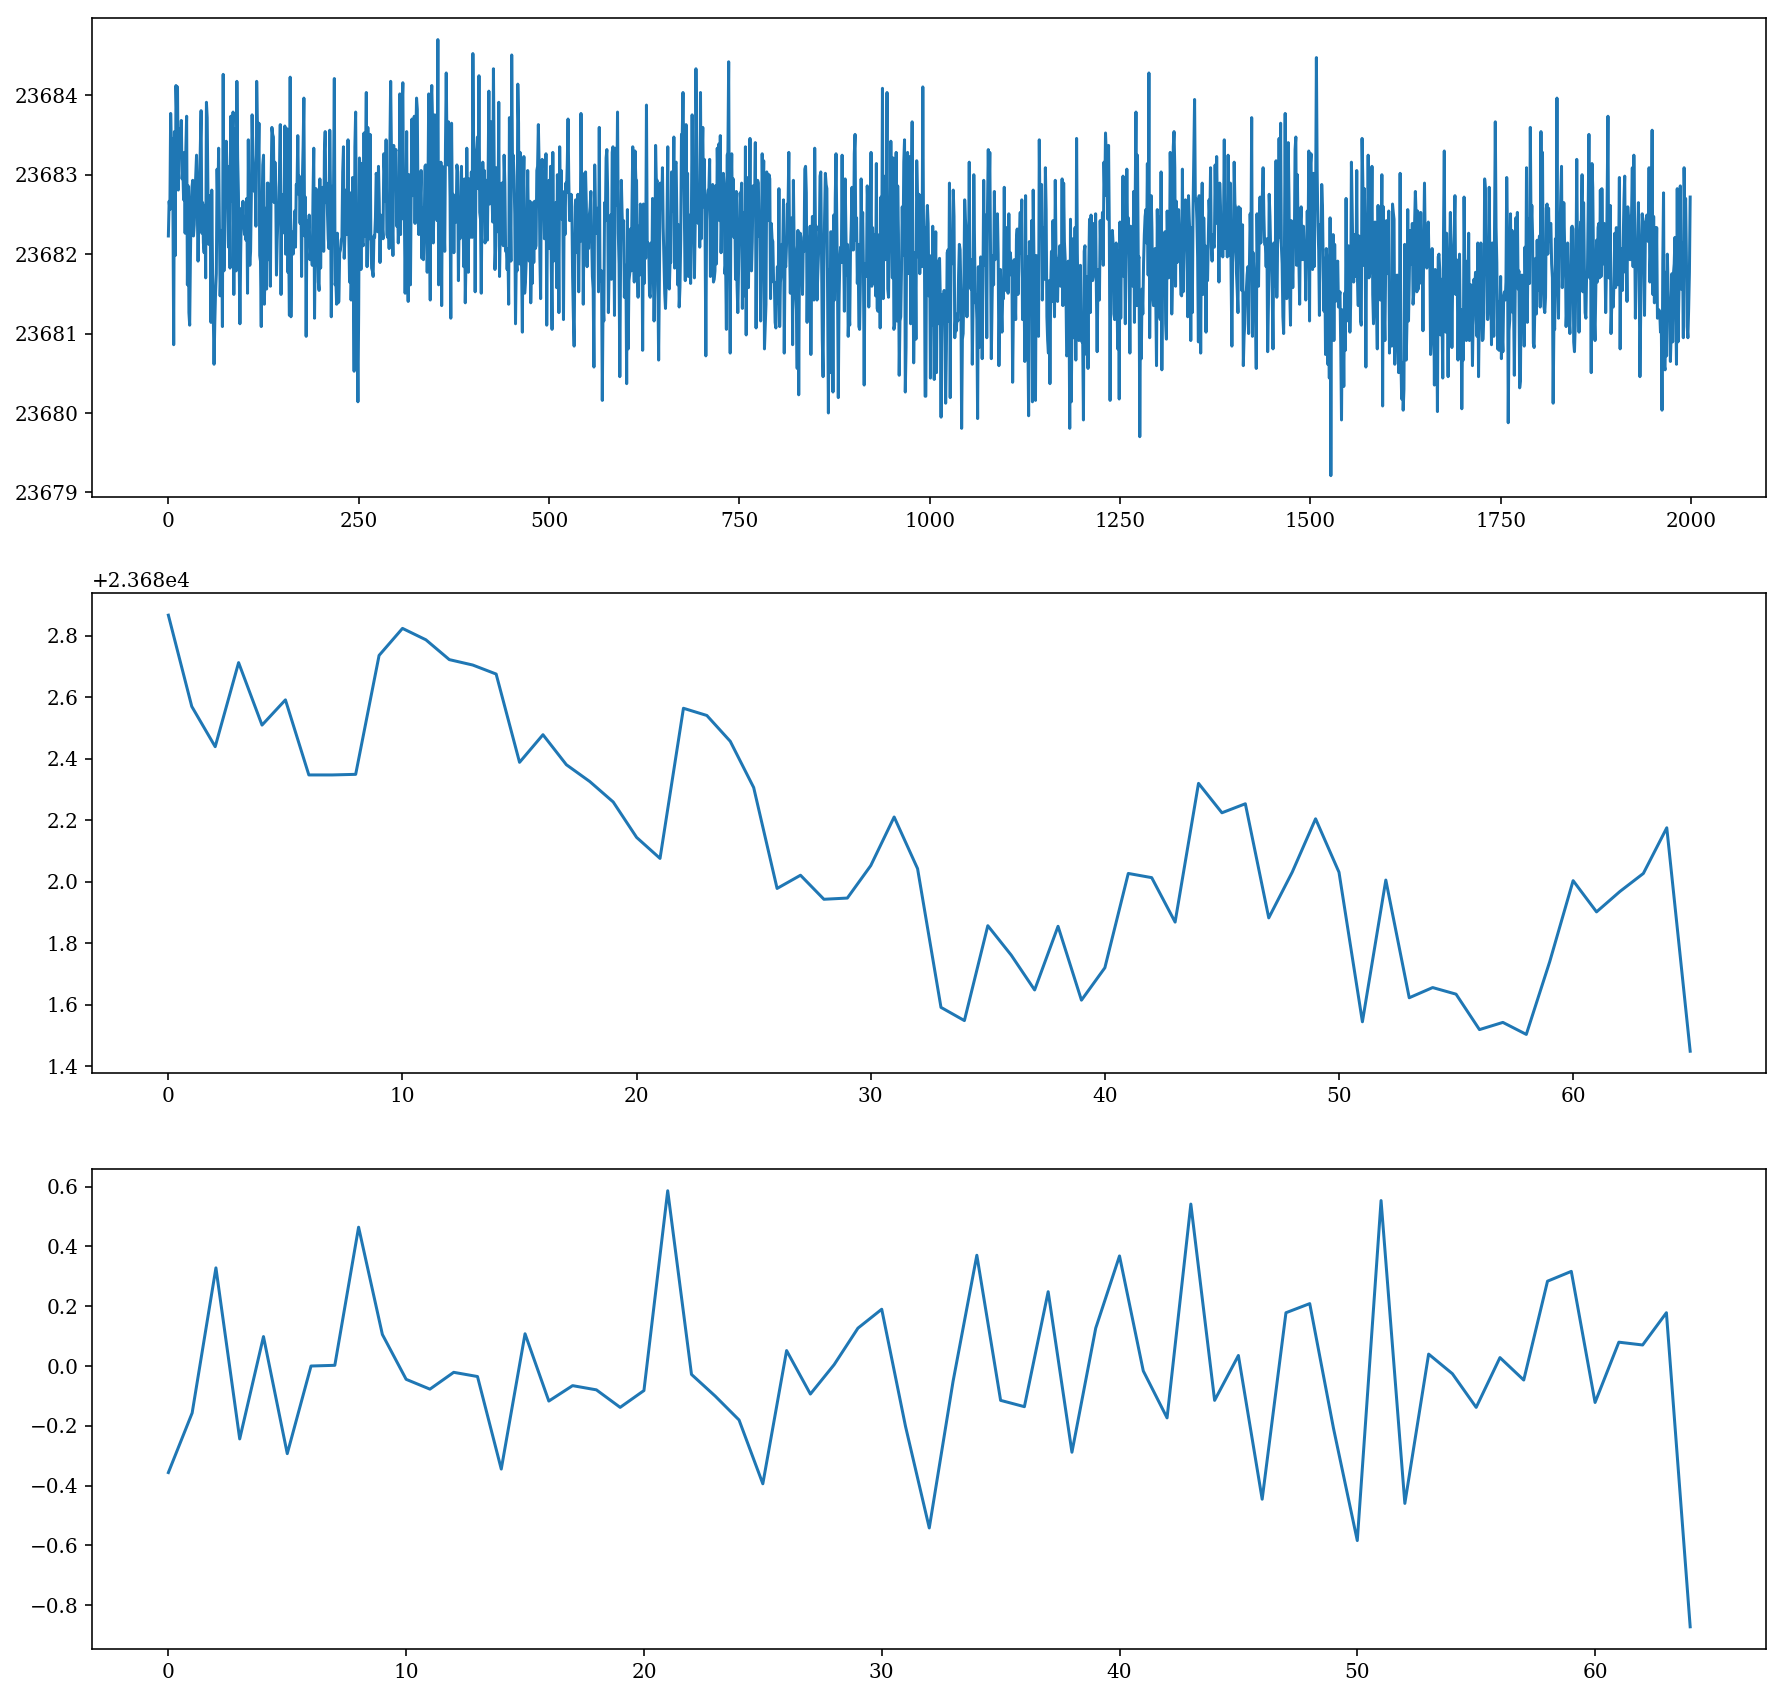

In [565]:
plt.figure(figsize=(15,15))
plt.subplot(311)
plt.plot(bias)
#plt.plot([1232,1233],[bias[1232],bias[1233]],marker='o')

plt.subplot(312)
n_smooth = 30
bias_smoothed = sum([bias[i:i-n_smooth:n_smooth] for i in range(n_smooth)])/n_smooth
plt.plot((bias_smoothed))

d_smooth = (bias_smoothed[1:] - bias_smoothed[:-1])/bias.std()
plt.subplot(313)
plt.plot(d_smooth)

jumps_smooth = np.where(d_smooth > 1.5)[0].flatten()
print('Noise: ' + str(bias.std()))
print(jumps_smooth)

In [563]:
def step(x,a,b,shift):  
    return b + shift*np.heaviside(x - a,0.5)

In [189]:
pixel_scale = 5
def tanh_fit(x,a,b,shift,scale):
    return b + shift*np.tanh(2*(x-a)/scale)

990
Bright low: 1101
Bright high: 1103
Bright pixel: 229430.75


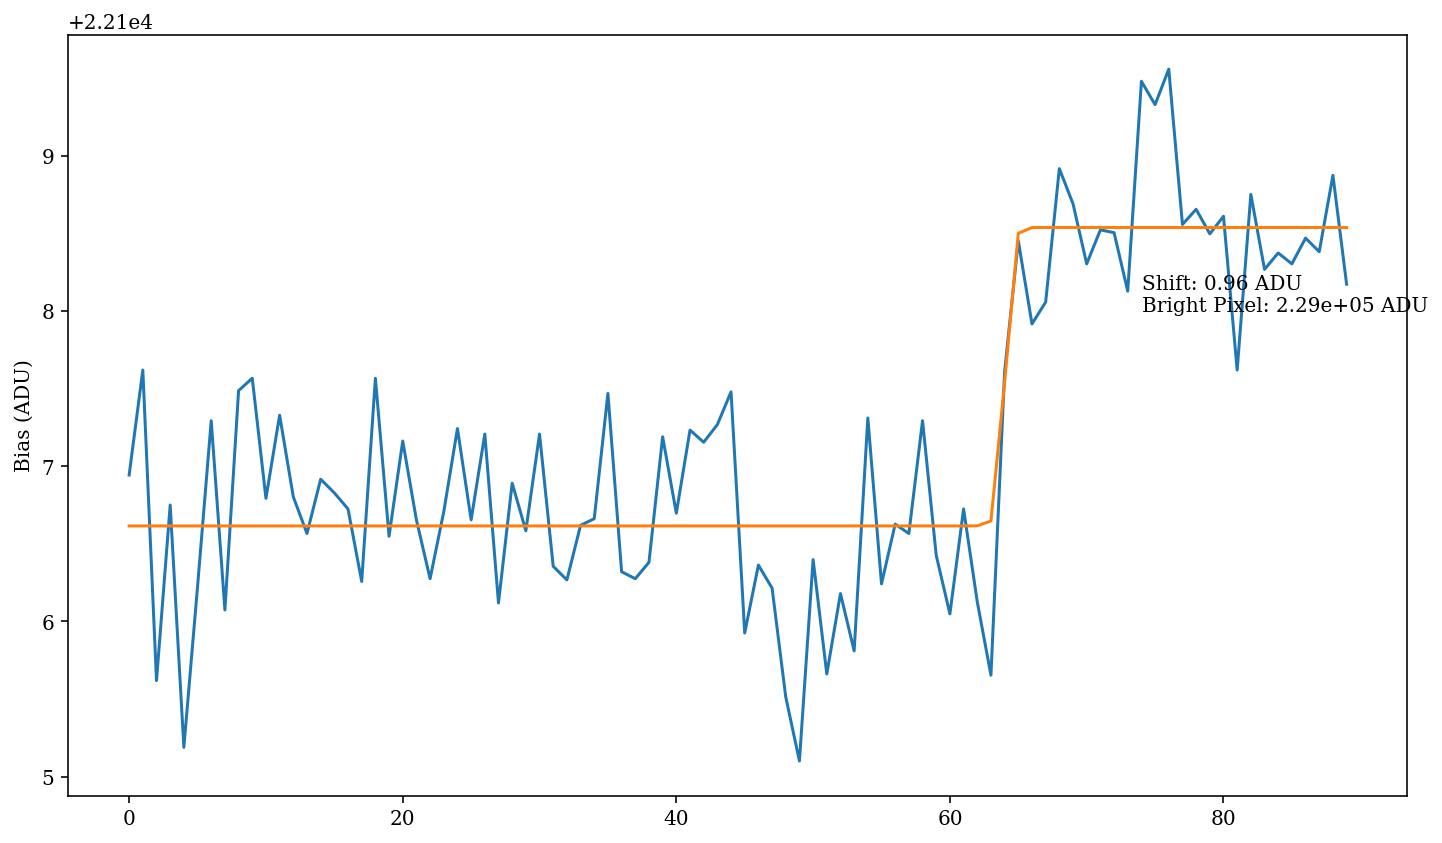

In [377]:
for i in range(len(jumps_smooth)):
    fig = plt.figure(figsize=(12,7))
    left_pixel  = int((jumps_smooth[i]-1)*n_smooth)
    right_pixel = int((jumps_smooth[i]+2)*n_smooth)
    if left_pixel  < 0: left_pixel = 0
    if right_pixel >= len(bias): right_pixel = len(bias) - 1
        
    n_window = right_pixel-left_pixel
    bias_window = bias[left_pixel:right_pixel]
    print(left_pixel)
    #params, cov = curve_fit(tanh_fit, np.arange(n_window), bias_window,\
    #                        p0=[n_window/2,bias_window.mean(),max(bias_window)-min(bias_window)], \
    #                        bounds=((0,min(bias_window),0),(n_window-1, max(bias_window), max(bias_window)-min(bias_window))))
    params, cov = curve_fit(tanh_fit, np.arange(n_window), bias_window,\
                            p0=[n_window/2,bias_window.mean(),max(bias_window)-min(bias_window),pixel_scale], \
                            bounds=((0,min(bias_window),0,1),(n_window-1, max(bias_window), max(bias_window)-min(bias_window),10)))
    
    bright_low  = left_pixel+int(params[0]-params[-1]) + len(image_untrimmed.array) - amp.ny
    bright_high = left_pixel+int(params[0]+params[-1]) + len(image_untrimmed.array) - amp.ny
    print("Bright low: " + str(bright_low))
    print("Bright high: " + str(bright_high))
    #if bright_low < 0:          bright_low = 
    #if bright_high >= len(bias): bright_high = len(bias) - 1
    bright_val = np.amax(image.array[bright_low : bright_high,:])
    bright_loc = np.where(image.array == bright_val)
    print('Bright pixel: ' + str(bright_val))
    
    plt.plot(bias_window)
    plt.plot(tanh_fit(np.arange(n_window), *params))
    plt.ylabel('Bias (ADU)')
    plt.text(params[0] + 10, int(params[1]+params[2]/2.),'Shift: ' + '{:.2f} ADU\nBright Pixel: {:.2e} ADU'.format(params[2], bright_val))


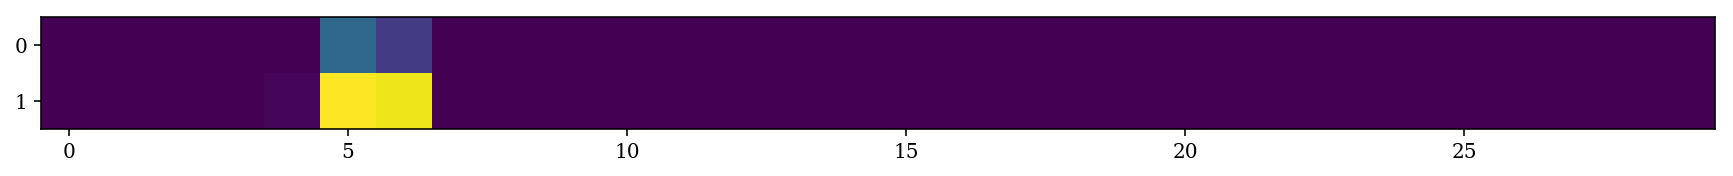

In [384]:
plt.figure(figsize=(15,3))
plt.imshow(image.array[bright_low : bright_high,:30])

In [280]:
len(image.array)

2000

In [345]:
bright_loc

(array([  26,   49,   53,   56,   58,   58,   61,   78,   92,  101,  106,
         111,  114,  116,  139,  142,  158,  181,  190,  224,  226,  233,
         237,  243,  246,  263,  268,  281,  282,  294,  313,  314,  334,
         338,  343,  353,  417,  432,  438,  450,  454,  457,  460,  461,
         512,  521,  522,  531,  541,  584,  592,  601,  602,  613,  620,
         638,  640,  652,  657,  660,  680,  688,  697,  699,  704,  718,
         735,  743,  747,  772,  774,  779,  781,  814,  837,  856,  863,
         874,  878,  885,  900,  914,  932,  960,  977,  987, 1009, 1019,
        1021, 1024, 1025, 1040, 1053, 1075, 1099, 1139, 1140, 1151, 1179,
        1212, 1214, 1217, 1224, 1224, 1242, 1263, 1286, 1287, 1319, 1325,
        1334, 1345, 1348, 1359, 1391, 1403, 1412, 1413, 1419, 1426, 1427,
        1433, 1440, 1458, 1468, 1471, 1490, 1491, 1506, 1522, 1539, 1561,
        1564, 1580, 1583, 1588, 1591, 1592, 1603, 1635, 1637, 1665, 1689,
        1700, 1712, 1734, 1738, 1741, 

In [155]:
params

array([4.28552175e+00, 2.15590649e+04, 1.39103250e+01, 1.00000000e+01])

In [216]:
image.array.shape

(2000, 509)

In [107]:
np.amax(image.array[])

243439.0

In [169]:
u = TVRegDiff( bias, 1000, .05,plotflag=0,diagflag=0)#, u0, scale, ep, dx, plotflag, diagflag );

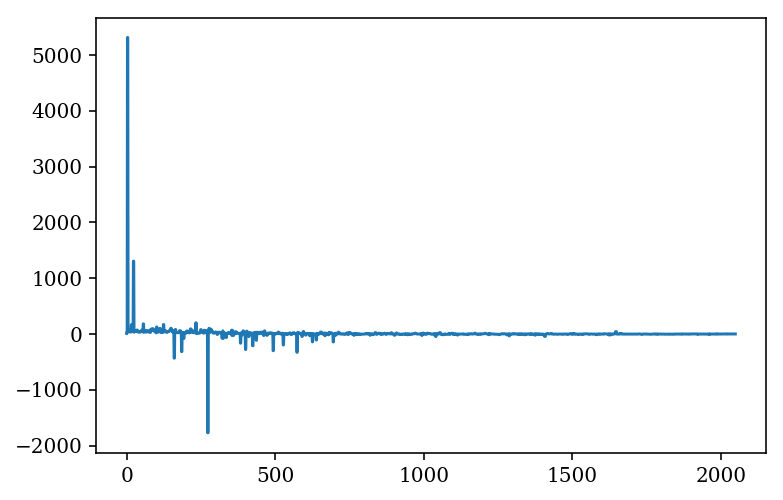

In [170]:
plt.plot(u)

In [561]:
len(u)

2049

In [269]:
bp = lsst.eotest.sensor.BrightPixels(ccd, 13, data[0].header['EXPTIME'],1)

In [270]:
bp.find()

([(117, 857), (118, 856), (118, 857), (289, 1232), (289, 1233)], [288])

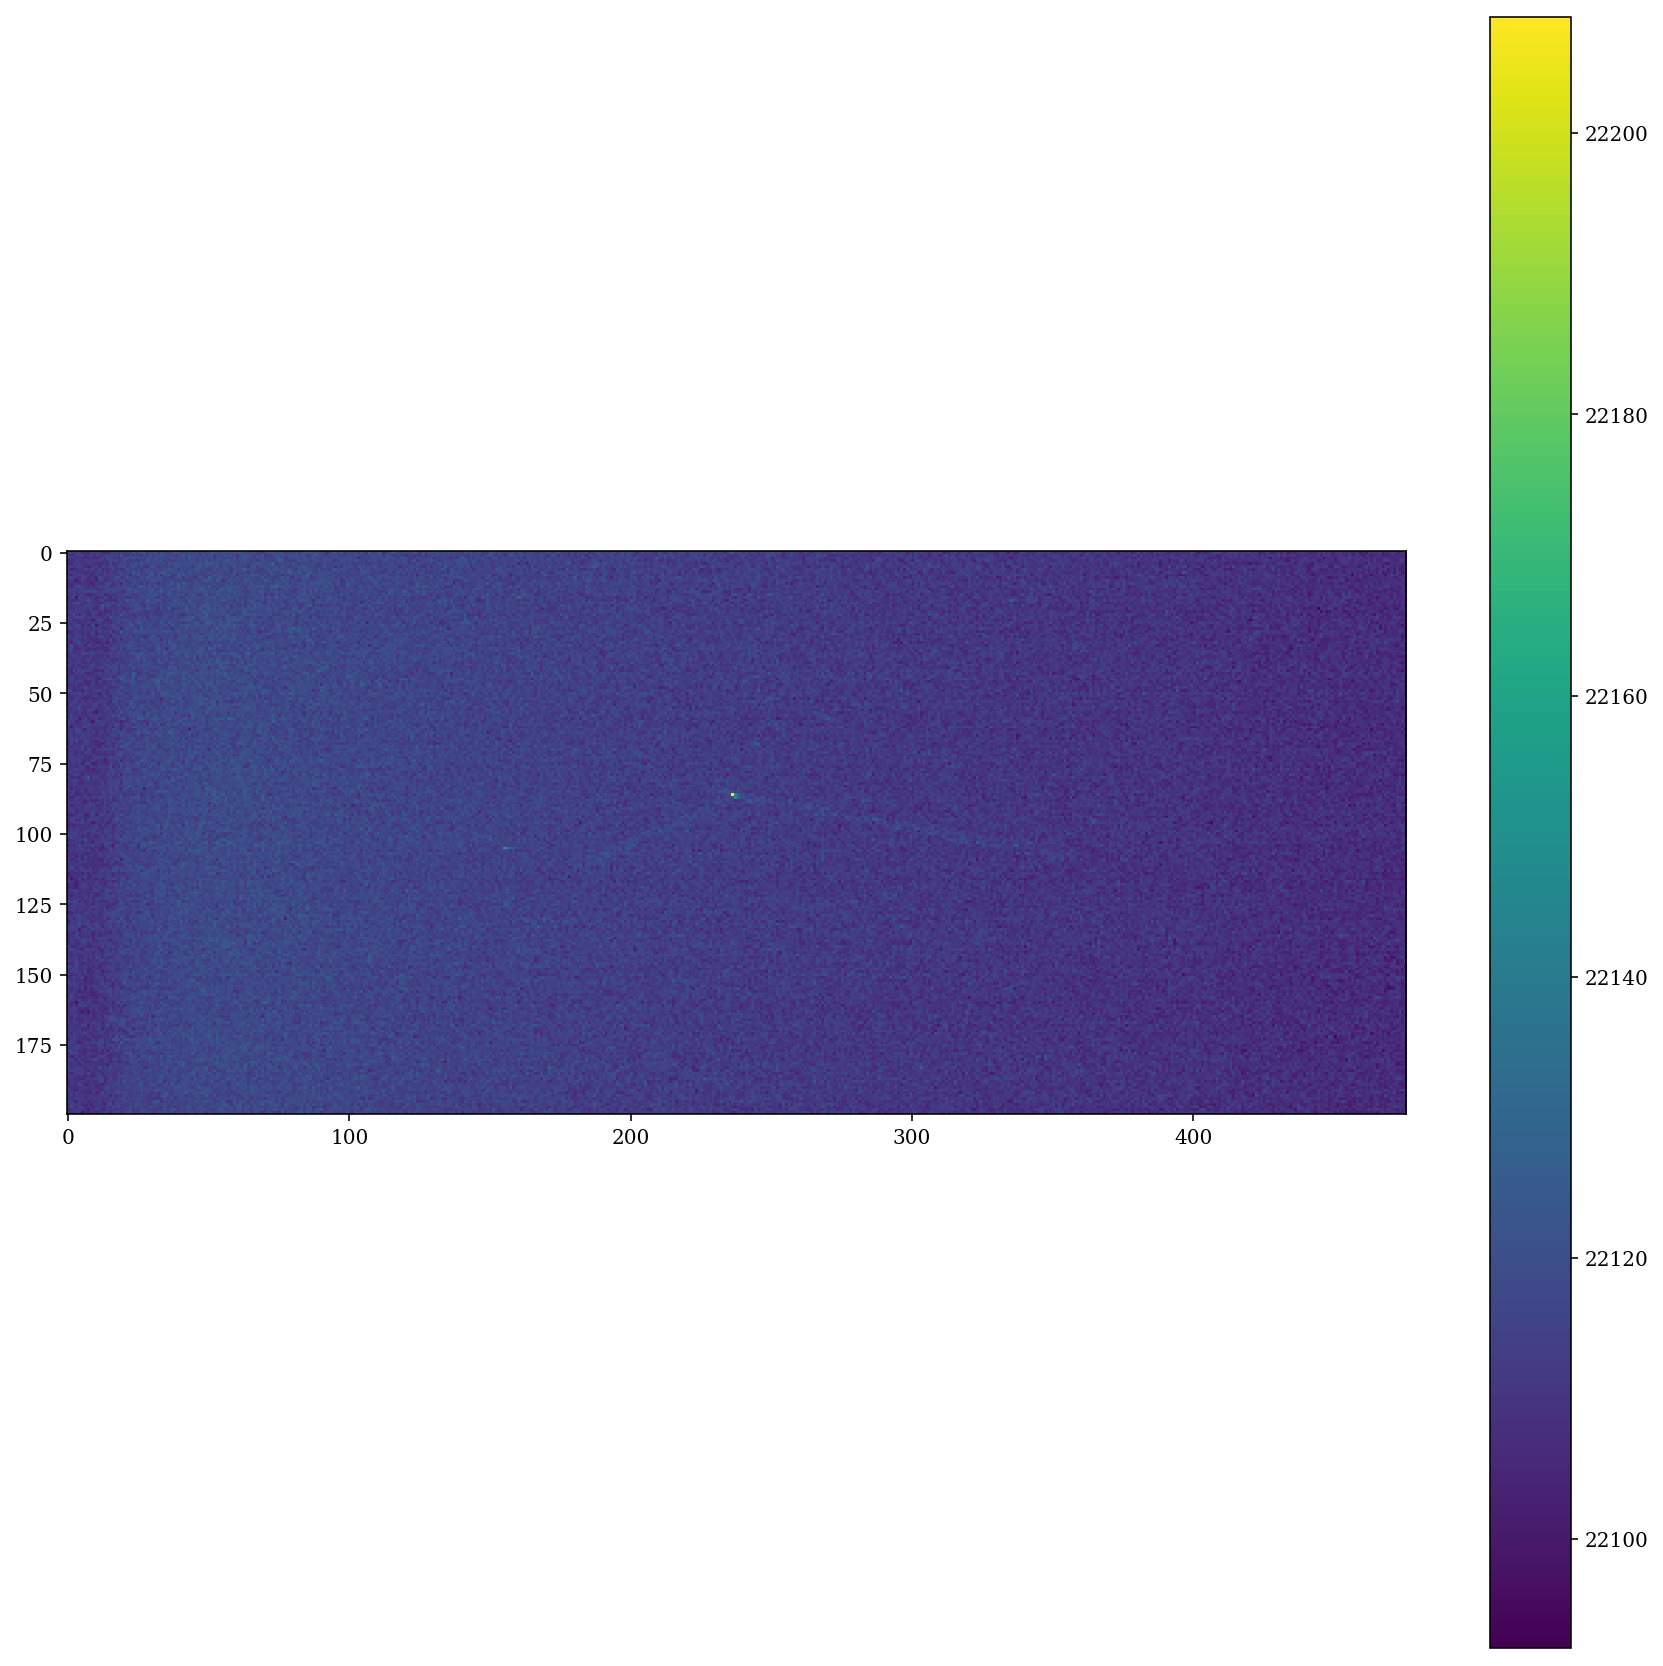

In [352]:
fig = plt.figure(figsize=(15,15))
plt.imshow(image_untrimmed.array[-200:,100:])#,clim=(22000,22500))#,clim=(24120,24130))
#plt.plot(np.array([289,289])-100,np.array([1232,1233])-800,marker='.')
plt.colorbar()
fig.patch.set_facecolor('white')

In [570]:
data[0].header

SIMPLE  =                    T / Java FITS: Fri May 10 16:35:09 PDT 2019        
BITPIX  =                    8 / bits per data value                            
NAXIS   =                    0 / number of axes                                 
EXTEND  =                    T / Extensions are permitted                       
DATE    = '2019-05-14T18:13:54.527' / Creation Date and Time of File            
DATE-OBS= '2019-05-14T18:13:49.270' / Date of the observation (image acquisition
MJD     =    58617.75965887727 / Modified Julian Date that the file was written 
MJD-OBS = 58617.75959803257 / Modified Julian Date (5 decimal places) of image a
RUNNUM  = '10932   '           / The Run Number                                 
IMAGETAG= '1557857629270'      / Image tag (CCS/VST)                            
TSTAND  = 'TS8     '           / Which Test stand at the site was used          
CONTNUM = '000018ee0d79'       / CCD Controller Serial Number                   
SEQFILE = 'ts8-itl-2s-v6.1-I

In [390]:

def threestep(x,n,bias,a1,a2,a3,s1,s2,s3):
    if n > 3 or n < 0:
        return 0
    if n>=0:
        val = step(x,bias,a1,s1)
    if n>=1:
        val += step(x,0,a2,s2)
    if n>=2:
        val += step(x,0,a3,s3)
    
    return val

In [403]:
def levels(x,a1,a2,a3,b0,b1,b2,b3):
    print(x)
    if not ((a3 >= a2) and (a2 >= a1)):
        return -10e10
    if x >= a3:
        return b3
    if x >= a2:
        return b2
    if x >= a1:
        return b1
    return b0

In [327]:
max([max(biasimage.array[i,:])-min(biasimage.array[i,:]) for i in range(len(biasimage.array))])

0.0

In [335]:
params, cov = curve_fit((lambda x,a,b,shift : b + shift*np.heaviside(x - a, 0.5)), range(len(bias)), bias,p0=[600,24121,6])

/Users/duncan/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [393]:
params3, cov3 = curve_fit(threestep, range(len(bias)), bias,p0=[0,600,,,0,4,4,0])

/Users/duncan/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [404]:
paramsl, covl = curve_fit(levels, range(len(bias)), bias,p0=[2,600,700,24121,6,600,25000])

range(0, 2048)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [394]:
params3

array([3.0000e+00, 2.4121e+04, 6.0000e+00, 6.0000e+02, 0.0000e+00,
       4.0000e+00, 4.0000e+00, 0.0000e+00])

NameError: name 'threestep' is not defined

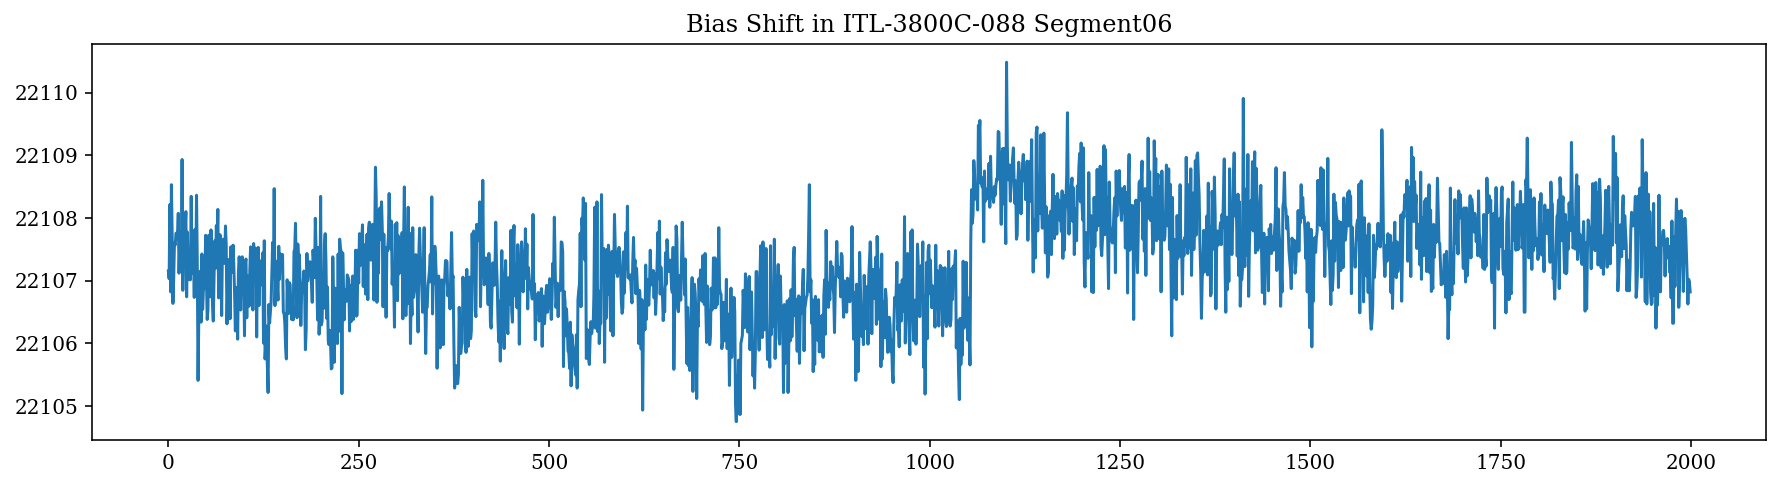

In [361]:
fig = plt.figure(figsize=(15,8))
#gs = gridspec.GridSpec(2,1,fig)

ax1 = plt.subplot(211)
plt.rc("font",family="serif")

plt.title('Bias Shift in ' + data[0].header['LSST_NUM'] + ' ' + data[10].header['EXTNAME'])
plt.plot(bias)
plt.plot(threestep(range(len(bias)), *params3))
plt.ylabel('Bias (ADU)')
plt.text(params[0] + 50, int(params[1]+params[2]/2.),'Shift: ' + '{:.2f} ADU\nBright Pixel: {:.2e} ADU'.format(params[2], bright))

ax2 = plt.subplot(212,sharex=ax1)
flatim = np.ravel(image.array)
clow  = np.partition(flatim, int(0.01*len(flatim)))[int(0.01*len(flatim))]
chigh = np.partition(flatim, int(0.98*len(flatim)))[int(0.98*len(flatim))]+20
plt.imshow(np.transpose(image.array),clim=(clow,chigh),cmap='gist_heat')
plt.colorbar(orientation='horizontal',label='ADU')
ax2.set_aspect('auto')

fig.patch.set_facecolor('white')

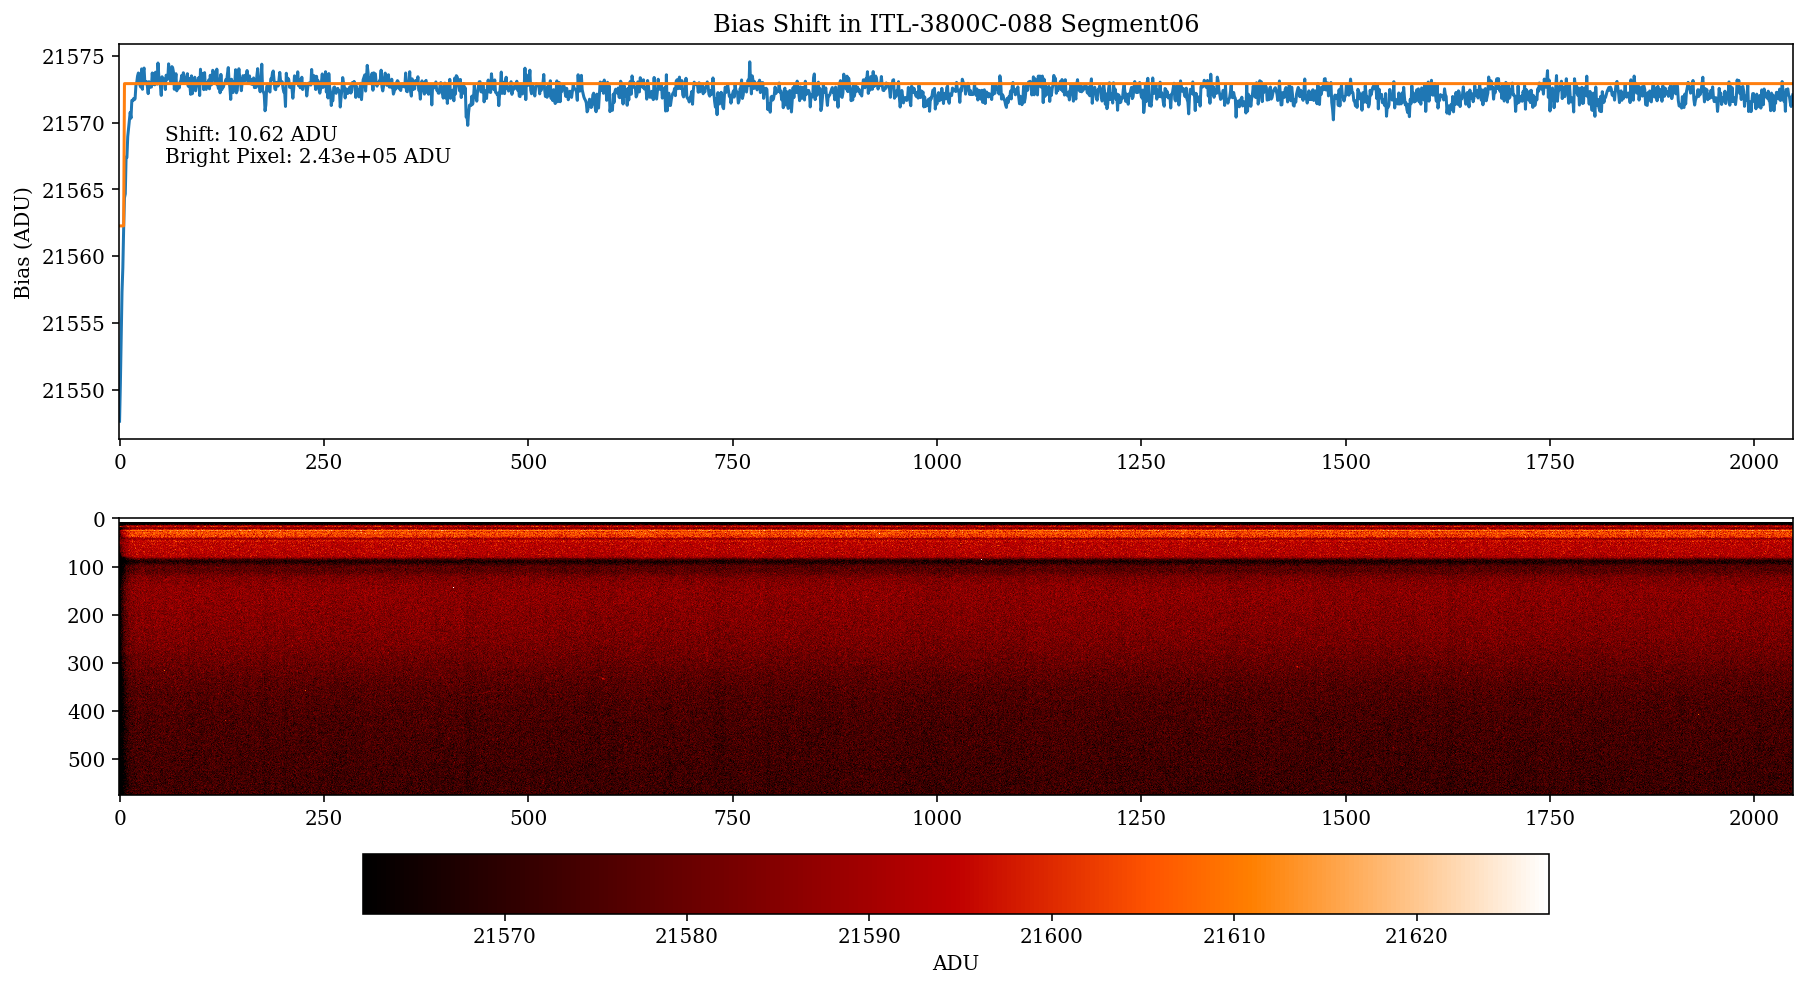

In [126]:
fig = plt.figure(figsize=(15,8))
#gs = gridspec.GridSpec(2,1,fig)

ax1 = plt.subplot(211)
plt.rc("font",family="serif")

plt.title('Bias Shift in ' + data[0].header['LSST_NUM'] + ' ' + data[10].header['EXTNAME'])
plt.plot(bias)
plt.plot(step(range(len(bias)), params[0],params[1],params[2]))
plt.ylabel('Bias (ADU)')
plt.text(params[0] + 50, int(params[1]+params[2]/2.),'Shift: ' + '{:.2f} ADU\nBright Pixel: {:.2e} ADU'.format(params[2], bright))

ax2 = plt.subplot(212,sharex=ax1)
flatim = np.ravel(image.array)
clow  = np.partition(flatim, int(0.01*len(flatim)))[int(0.01*len(flatim))]
chigh = np.partition(flatim, int(0.98*len(flatim)))[int(0.98*len(flatim))]+20
plt.imshow(np.transpose(image.array),clim=(clow,chigh),cmap='gist_heat')
plt.colorbar(orientation='horizontal',label='ADU')
ax2.set_aspect('auto')

fig.patch.set_facecolor('white')

In [356]:
sorted(flatim)[::-1]

[237510.25,
 235577.25,
 234693.75,
 127769.25,
 125492.75,
 25541.25,
 25541.25,
 25541.25,
 25541.25,
 25540.75,
 25540.75,
 25540.75,
 25540.75,
 25540.75,
 25540.75,
 25540.75,
 25540.75,
 25540.75,
 25540.75,
 25540.75,
 25540.25,
 25540.25,
 25540.25,
 25540.25,
 25540.25,
 25540.25,
 25540.25,
 25540.25,
 25540.25,
 25540.25,
 25540.25,
 25540.25,
 25540.25,
 25540.25,
 25540.25,
 25540.25,
 25540.25,
 25540.25,
 25540.25,
 25540.25,
 25540.25,
 25540.25,
 25540.25,
 25540.25,
 25539.75,
 25539.75,
 25539.75,
 25539.75,
 25539.75,
 25539.75,
 25539.75,
 25539.75,
 25539.75,
 25539.75,
 25539.75,
 25539.75,
 25539.75,
 25539.75,
 25539.75,
 25539.75,
 25539.75,
 25539.75,
 25539.75,
 25539.75,
 25539.75,
 25539.75,
 25539.75,
 25539.75,
 25539.75,
 25539.75,
 25539.75,
 25539.75,
 25539.75,
 25539.75,
 25539.75,
 25539.75,
 25539.75,
 25539.75,
 25539.75,
 25539.75,
 25539.75,
 25539.75,
 25539.75,
 25539.75,
 25539.75,
 25539.75,
 25539.75,
 25539.75,
 25539.75,
 25539.75,
 2553

In [80]:
trimmed_image = imutils.trim(im, amp.imaging)
ti = trimmed_image.getArray()

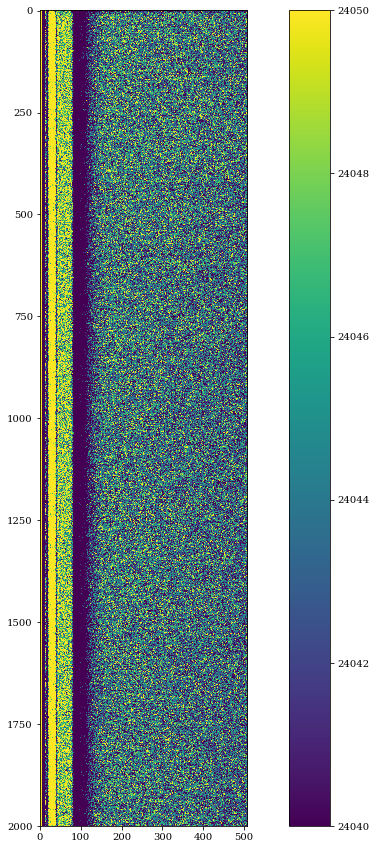

In [316]:
plt.figure(figsize=(15,15))
plt.imshow(ti,clim=(24040,24050))
plt.colorbar()

In [109]:
fits.getheader('data/ITL-3800C-088_median_dark_bp.fits',1)

XTENSION= 'IMAGE   '           / marks beginning of new HDU                     
BITPIX  =                  -32 / bits per data value                            
NAXIS   =                    2 / number of axis                                 
NAXIS1  =                  576 / size of the n'th axis                          
NAXIS2  =                 2048 / size of the n'th axis                          
PCOUNT  =                    0 / Required value                                 
GCOUNT  =                    1 / Required value                                 
HEADVER =                    1 / Version number of header                       
CHANNEL =                    1                                                  
EXTNAME = 'Segment10'                                                           
CCDSUM  = '1 1     '                                                            
AVERAGE =    24043.71486005802                                                  
AVGBIAS =    24040.954757690

In [101]:
data_directory = os.fsencode('data')
images = {}
for file in os.listdir(data_directory):
    filename = os.fsdecode(file)
    if filename.endswith('.fits'): 
        images[file] = get_CCD_from_fits('data' + '/' + filename, bias=True)

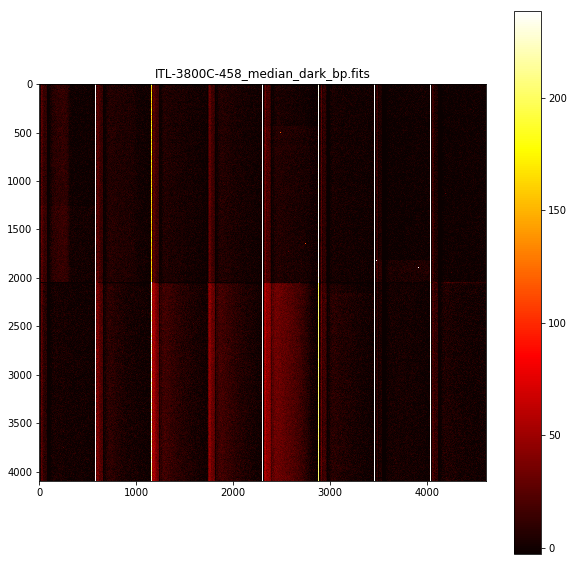

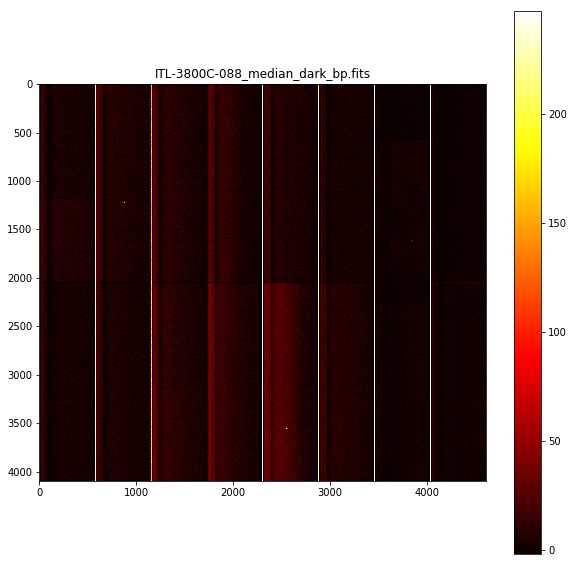

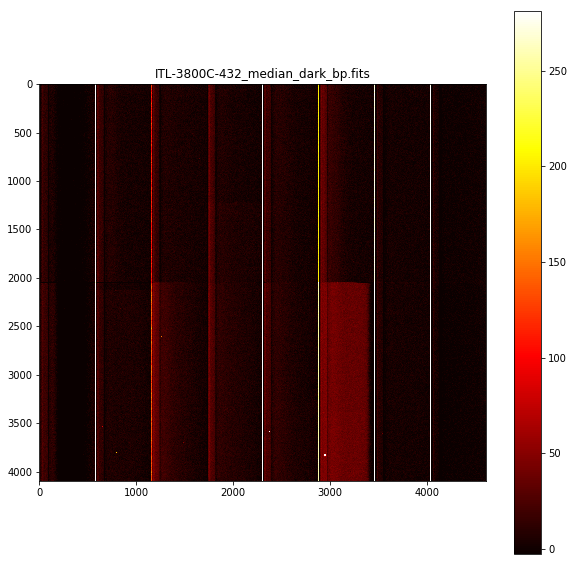

In [102]:

for file in os.listdir(data_directory):
    filename = os.fsdecode(file)
    if filename.endswith('.fits'): 
        plt.figure(figsize=(10,10))
        flatim = np.ravel(images[file])
        low  = np.partition(flatim, int(0.15*len(flatim)))[int(0.15*len(flatim))]
        high = np.partition(flatim, int(0.99*len(flatim)))[int(0.99*len(flatim))]
        plt.imshow(images[file],clim=(low,high),cmap='hot')
        plt.colorbar()
        plt.title(file.decode())
        plt.show()
        continue
    else:
        continue